In [1]:
import random
import warnings
import os
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.optim import SGD
from torch.optim.lr_scheduler import LambdaLR

from tllib.modules.regressor import Regressor
from tllib.alignment.dann import DomainAdversarialLoss
from tllib.modules.domain_discriminator import DomainDiscriminator
import tllib.vision.datasets.regression as datasets
import tllib.vision.models as models
from tllib.utils.data import ForeverDataIterator
from tllib.utils.meter import AverageMeter, ProgressMeter
from tllib.utils.logger import CompleteLogger
from tllib.utils.analysis import collect_feature, tsne, a_distance

from models import model_o3_err, model_o3_err_cosmology, model_o3_err_18layers, model_o3_err_da
from dataloader import create_dataset_multifield

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# logger = CompleteLogger('dann', 'train')

seed = 1
random.seed(1)
torch.manual_seed(1)
cudnn.deterministic = True
warnings.warn('You have chosen to seed training. '
                'This will turn on the CUDNN deterministic setting, '
                'which can slow down your training considerably! '
                'You may see unexpected behavior when restarting '
                'from checkpoints.')
cudnn.benchmark = True

/tmp/ipykernel_129197/2356918065.py:7: UserWarning: You have chosen to seed training. This will turn on the CUDNN deterministic setting, which can slow down your training considerably! You may see unexpected behavior when restarting from checkpoints.
  warnings.warn('You have chosen to seed training. '


## Load Dataset

In [4]:
batch_size = 64
splits     = 15

# Normalization
fmaps_norm = ['maps_T_TNG.npy']
# fmaps_norm = ['maps_T_SIMBA.npy']
# fmaps_norm = [None]

# data augmentation
rot_flip_in_mem = False

In [5]:
# load TNG dataset (source)
fmaps = ['maps_T_TNG.npy']
fparams = '2D_maps/data/params_LH_IllustrisTNG.txt'
TNG_train_loader = create_dataset_multifield('train', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=rot_flip_in_mem, verbose=True)
TNG_valid_loader = create_dataset_multifield('valid', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=True,  verbose=True)
# TNG_test_loader = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
#                                          rot_flip_in_mem=False, verbose=True)

# load SIMBA dataset (target)
fmaps = ['maps_T_SIMBA.npy']
fparams = '2D_maps/data/params_LH_SIMBA.txt'
SIMBA_train_loader = create_dataset_multifield('train', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=rot_flip_in_mem, verbose=True)
SIMBA_valid_loader = create_dataset_multifield('valid', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=True,  verbose=True)
# SIMBA_test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
#                                          rot_flip_in_mem=False, verbose=True)

13500
Found 1 channels
Reading data...
1.502e+03 < F(all|orig) < 8.669e+07
3.177 < F(all|resc)  < 7.938


KeyboardInterrupt: 

In [6]:
train_source_loader = TNG_train_loader
train_target_loader = SIMBA_train_loader
val_source_loader = TNG_valid_loader
val_target_loader = SIMBA_valid_loader

# train_source_loader = SIMBA_train_loader
# train_target_loader = TNG_train_loader
# val_source_loader = SIMBA_valid_loader
# val_target_loader = TNG_valid_loader

train_source_iter = ForeverDataIterator(train_source_loader)
train_target_iter = ForeverDataIterator(train_target_loader)

## Load Model

In [6]:
# CNN
channels   = 1
hidden     = 11 
dr         = 0.4

# factors = ['Omega', 'sigma', 'ASN1', 'ASN2', 'AGN1', 'AGN2']
# factors_error = ['Omega_err', 'sigma_err', 'ASN1_err', 'ASN2_err', 'AGN1_err', 'AGN2_err']
# factors = ['Omega', 'sigma']
# factors_error = ['Omega_err', 'sigma_err']
factors = ['Omega']
# factors_error = ['Omega_err']
factors_error = []
num_factors = len(factors) + len(factors_error)

backbone_type = 'VGG' # 'CNN', 'VGG', 'VGG_pretrain'

In [7]:
if backbone_type == 'CNN':
    backbone = model_o3_err_da(hidden, dr, channels)
    bottleneck = nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        nn.Flatten(),
        nn.Linear(128*hidden, 256),
        nn.ReLU()
    )
elif backbone_type == 'VGG':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13', pretrained=True) # out_features=1000
    backbone = model.features
    # backbone = models.__dict__['resnet18'](pretrained=True)
    bottleneck = nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.5)
    )
elif backbone_type == 'VGG_pretrain':
    backbone = torch.hub.load('pytorch/vision:v0.10.0', 'vgg13', pretrained=True) # out_features=1000
    backbone.classifier[6] = nn.Linear(4096, num_factors)
    checkpoint = torch.load('best_weights_vgg13.pt', map_location=torch.device(device))
    backbone.load_state_dict(checkpoint)
    backbone.classifier[6] = nn.Linear(4096, 1000)
    bottleneck = nn.Sequential(
        # nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        # nn.Flatten(),
        nn.Linear(1000, 256),
        nn.ReLU(),
        nn.Dropout(0.5)
    )

head = nn.Sequential(
    nn.Linear(256, num_factors),
    # nn.Sigmoid()
)
regressor = Regressor(backbone=backbone, num_factors=num_factors, 
                    bottleneck=bottleneck, bottleneck_dim=256, 
                    head=head).to(device)
# print(regressor)
domain_discri = DomainDiscriminator(in_feature=regressor.features_dim, hidden_size=1024).to(device)

Using cache found in /home/jingyue/.cache/torch/hub/pytorch_vision_v0.10.0
/home/jingyue/anaconda3/envs/ce2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/jingyue/anaconda3/envs/ce2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

In [8]:
# === define optimizer and lr scheduler ===
lr=0.1
momentum=0.9
wd=0.001
lr_gamma=0.0001
lr_decay=0.75
# optimizer = SGD(regressor.get_parameters() + domain_discri.get_parameters(), lr, momentum=momentum,
#                 weight_decay=wd, nesterov=True)
# lr_scheduler = LambdaLR(optimizer, lambda x: lr * (1. + lr_gamma * float(x)) ** (-lr_decay))

# max_lr = 0.0036
max_lr = 0.00001
beta1 = 0.5
beta2 = 0.999
wd = 0.001
optimizer = torch.optim.AdamW(regressor.parameters(), lr=max_lr, weight_decay=wd, betas=(beta1, beta2))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)

# === define loss function ===
dann = DomainAdversarialLoss(domain_discri).to(device)
trade_off=0.01  # 0.001

epochs=100
print_freq=100
iters_per_epoch=212

In [9]:
def train(train_source_iter: ForeverDataIterator, train_target_iter: ForeverDataIterator,
          model: Regressor, domain_adv: DomainAdversarialLoss, optimizer: SGD,
          lr_scheduler: LambdaLR, epoch: int, trade_off: float, loss_type: str):
    # mse_losses = AverageMeter('MSE Loss', ':6.3f')
    cmd_losses_s = AverageMeter('CMD Loss (s)', ':6.3e')
    cmd_losses_t = AverageMeter('CMD Loss (t)', ':6.3e')
    dann_losses = AverageMeter('DANN Loss', ':6.3f')
    domain_accs = AverageMeter('Domain Acc', ':3.1f')
    # mae_losses_s = AverageMeter('MAE Loss (s)', ':6.3f')
    # mae_losses_t = AverageMeter('MAE Loss (t)', ':6.3f')

    progress = ProgressMeter(
        len(train_source_loader),
        [cmd_losses_s, cmd_losses_t, dann_losses, domain_accs],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()
    domain_adv.train()

    for i in range(iters_per_epoch):
        optimizer.zero_grad()

        x_s, labels_s = next(train_source_iter)
        x_s = x_s.to(device)
        labels_s = labels_s[:, :len(factors)].to(device).float()
        
        x_t, labels_t = next(train_target_iter)
        x_t = x_t.to(device)
        labels_t = labels_t[:, :len(factors)].to(device).float()
        
        if 'VGG' in backbone_type:
            x_s = x_s.repeat(1, 3, 1, 1)
            x_t = x_t.repeat(1, 3, 1, 1)

        # compute output
        y_s, f_s = model(x_s)
        y_t, f_t = model(x_t)

        # print(f_s.shape)
        # print(f_t.shape)

        if loss_type != 'mean':
            y_s_m = y_s[:, :len(factors)]
            y_s_e = y_s[:, len(factors):]
            loss1_s = torch.mean((y_s_m - labels_s)**2,                axis=0)
            loss2_s = torch.mean(((y_s_m - labels_s)**2 - y_s_e**2)**2, axis=0)
            cmd_loss_s  = torch.mean(torch.log(loss1_s) + torch.log(loss2_s))

            y_t_m = y_t[:, :len(factors)]
            y_t_e = y_t[:, len(factors):]
            loss1_t = torch.mean((y_t_m - labels_t)**2,                axis=0)
            loss2_t = torch.mean(((y_t_m - labels_t)**2 - y_t_e**2)**2, axis=0)
            cmd_loss_t  = torch.mean(torch.log(loss1_t) + torch.log(loss2_t))
        else:
            y_s_m = y_s[:, :len(factors)]
            cmd_loss_s = torch.mean((y_s_m - labels_s)**2,                axis=0)

            y_t_m = y_t[:, :len(factors)]
            cmd_loss_t = torch.mean((y_t_m - labels_t)**2,                axis=0)

        transfer_loss = domain_adv(f_s, f_t)
        loss = cmd_loss_s + transfer_loss * trade_off
        # loss = cmd_loss_s
        domain_acc = domain_adv.domain_discriminator_accuracy

        # mse_loss = F.mse_loss(y_s, labels_s)
        # mae_loss_s = F.l1_loss(y_s, labels_s)
        # mae_loss_t = F.l1_loss(y_t, labels_t)
        # transfer_loss = domain_adv(f_s, f_t)
        # loss = mse_loss + transfer_loss * trade_off
        # domain_acc = domain_adv.domain_discriminator_accuracy

        # mse_losses.update(mse_loss.item(), x_s.size(0))
        cmd_losses_s.update(cmd_loss_s.item(), x_s.size(0))
        cmd_losses_t.update(cmd_loss_t.item(), x_s.size(0))
        dann_losses.update(transfer_loss.item(), x_s.size(0))
        # mae_losses_s.update(mae_loss_s.item(), x_s.size(0))
        # mae_losses_t.update(mae_loss_t.item(), x_s.size(0))
        domain_accs.update(domain_acc.item(), x_s.size(0))

        # compute gradient and do SGD step
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

        if i % print_freq == 0:
            progress.display(i)


In [10]:
def validate(val_loader, model, factors, device, loss_type):
    cmd_losses_s = AverageMeter('CMD Loss (s)', ':6.3e')
    # mae_losses = [AverageMeter('mae {}'.format(factor), ':6.3f') for factor in factors]
    progress = ProgressMeter(
        len(val_loader), [cmd_losses_s], prefix='Test: ')

    num_maps = 0
    for x,y in val_loader:
        num_maps += x.shape[0]
    params_true = np.zeros((num_maps, len(factors)), dtype=np.float32)
    params_NN   = np.zeros((num_maps, len(factors)), dtype=np.float32)
    points = 0

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            x_s = images.to(device)
            labels_s = target[:, :len(factors)].to(device).float()

            if 'VGG' in backbone_type:
                x_s = x_s.repeat(1, 3, 1, 1)

            # compute output
            y_s = model(x_s)

            if loss_type != 'mean':
                y_s_m = y_s[:, :len(factors)]
                y_s_e = y_s[:, len(factors):]
                loss1_s = torch.mean((y_s_m - labels_s)**2,                axis=0)
                loss2_s = torch.mean(((y_s_m - labels_s)**2 - y_s_e**2)**2, axis=0)
                cmd_loss_s  = torch.mean(torch.log(loss1_s) + torch.log(loss2_s))
            else:
                y_s_m = y_s[:, :len(factors)]
                cmd_loss_s = torch.mean((y_s_m - labels_s)**2,                axis=0)

            cmd_losses_s.update(cmd_loss_s.item(), x_s.size(0))
            
            # for j in range(len(factors)):
            #     mae_loss = F.l1_loss(output[:, j], target[:, j])
            #     mae_losses[j].update(mae_loss.item(), images.size(0))

            if i % (len(val_loader)-1) == 0:
                progress.display(i)

            params_true[points:points+x_s.shape[0]] = labels_s.cpu().numpy()
            params_NN[points:points+x_s.shape[0]]   = y_s_m.cpu().numpy()
            points    += x_s.shape[0]

        # for i, factor in enumerate(factors):
        #     print("{} MAE {mae.avg:6.3f}".format(factor, mae=mae_losses[i]))
        # mean_mae = sum(l.avg for l in mae_losses) / len(factors)

    minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])[:len(factors)]
    maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])[:len(factors)]
    params_true = params_true*(maximum - minimum) + minimum
    params_NN   = params_NN*(maximum - minimum) + minimum
    
    rel_error = np.sqrt(np.mean((params_true - params_NN)**2/params_true**2, axis=0))
    
    return cmd_losses_s.avg, rel_error


In [12]:
best_mae_s = 100000.
best_mae_t = 100000.
for epoch in range(epochs):
    # train for one epoch
    # print("lr", lr_scheduler.get_lr())
    train(train_source_iter, train_target_iter, regressor, dann, optimizer,
            lr_scheduler, epoch, trade_off, loss_type="mean")

    # evaluate on validation set
    mae_s, rel_error_s = validate(val_source_loader, regressor, factors, device, loss_type="mean")
    mae_t, rel_error_t = validate(val_target_loader, regressor, factors, device, loss_type="mean")

    # remember best mae and save checkpoint
    if mae_t < best_mae_t:
        torch.save(regressor.state_dict(), "dann/checkpoints/best_model.pth")
    best_mae_t = min(mae_t, best_mae_t)
    best_mae_s = min(mae_s, best_mae_s)
    if num_factors <= 2:
        print("Source: mean MAE {:6.3e} best MAE {:6.3e} Omega_m_RE {:6.3f}".format(mae_s, best_mae_s, rel_error_s[0]))
        print("Target: mean MAE {:6.3e} best MAE {:6.3e} Omega_m_RE {:6.3f}".format(mae_t, best_mae_t, rel_error_t[0]))
    else:
        print("Source: mean MAE {:6.3e} best MAE {:6.3e} Omega_m_RE {:6.3f} sigma_8_RE {:6.3f}".format(mae_s, best_mae_s, rel_error_s[0], rel_error_s[1]))
        print("Target: mean MAE {:6.3e} best MAE {:6.3e} Omega_m_RE {:6.3f} sigma_8_RE {:6.3f}".format(mae_t, best_mae_t, rel_error_t[0], rel_error_t[1]))
    
print("best_mae = {:6.3f}".format(best_mae_t))


Epoch: [0][  0/211]	CMD Loss (s) 3.064e-01 (3.064e-01)	CMD Loss (t) 3.529e-01 (3.529e-01)	DANN Loss  0.754 ( 0.754)	Domain Acc 46.1 (46.1)
Epoch: [0][100/211]	CMD Loss (s) 1.205e-02 (5.139e-02)	CMD Loss (t) 9.687e-02 (1.553e-01)	DANN Loss  0.716 ( 0.735)	Domain Acc 49.2 (47.0)
Epoch: [0][200/211]	CMD Loss (s) 8.026e-03 (3.381e-02)	CMD Loss (t) 4.609e-02 (1.147e-01)	DANN Loss  0.699 ( 0.735)	Domain Acc 53.1 (47.7)
Test: [ 0/94]	CMD Loss (s) 6.311e-03 (6.311e-03)
Test: [93/94]	CMD Loss (s) 5.148e-03 (7.292e-03)
Test: [ 0/94]	CMD Loss (s) 9.495e-02 (9.495e-02)
Test: [93/94]	CMD Loss (s) 7.389e-02 (6.430e-02)
Source: mean MAE 7.292e-03 best MAE 7.292e-03 Omega_m_RE  0.119
Target: mean MAE 6.430e-02 best MAE 6.430e-02 Omega_m_RE  0.359
Epoch: [1][  0/211]	CMD Loss (s) 1.641e-02 (1.641e-02)	CMD Loss (t) 7.014e-02 (7.014e-02)	DANN Loss  0.752 ( 0.752)	Domain Acc 47.7 (47.7)
Epoch: [1][100/211]	CMD Loss (s) 1.295e-02 (1.202e-02)	CMD Loss (t) 4.033e-02 (5.249e-02)	DANN Loss  0.766 ( 0.754)	Doma

KeyboardInterrupt: 

## Test

In [11]:
# load test set
fmaps = ['maps_T_TNG.npy']
fparams = '2D_maps/data/params_LH_IllustrisTNG.txt'
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

750
Found 1 channels
Reading data...
1.502e+03 < F(all|orig) < 8.669e+07
3.177 < F(all|resc)  < 7.938
-1.282 < F(all|norm) < 4.550


In [13]:
# load test set
fmaps = ['maps_T_SIMBA.npy']
fparams = '2D_maps/data/params_LH_SIMBA.txt'
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

750
Found 1 channels
Reading data...
2.215e+02 < F(all|orig) < 2.772e+11
2.345 < F(all|resc)  < 11.443
-2.301 < F(all|norm) < 8.844


In [18]:
fmodel = 'dann/checkpoints/best_model_2.pth'
fmodel = 'dann/checkpoints/best_model_vgg_0.1_11.pth'
fmodel = 'dann/checkpoints/best_model_vgg_2_0.001_13.pth'
fmodel = 'dann/checkpoints/best_model_vgg_1_0.8_norm.pth'
# fmodel = 'dann/checkpoints/best_model_vgg_2_0.1_norm.pth'
fmodel = 'dann/checkpoints/best_model.pth'
# fmodel = 'dann/checkpoints/best_model_vgg_1_0.01_norm.pth'


if os.path.exists(fmodel):
    checkpoint = torch.load(fmodel, map_location=torch.device(device))
    new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint.items()}
    regressor.load_state_dict(new_state_dict)
    
    # model.load_state_dict(torch.load(fmodel, map_location=torch.device(device)))
    print('Weights loaded')

Weights loaded


In [20]:
minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])[:len(factors)]
maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])[:len(factors)]

# get the number of maps in the test set
num_maps = 0
for x,y in test_loader:
      num_maps += x.shape[0]
print('\nNumber of maps in the test set: %d'%num_maps)

r2_list = []
n_test = 100
for i in tqdm(range(n_test)):
    # define the arrays containing the value of the parameters
    params_true = np.zeros((num_maps,len(factors)), dtype=np.float32)
    params_NN   = np.zeros((num_maps,len(factors)), dtype=np.float32)
    errors_NN   = np.zeros((num_maps,len(factors)), dtype=np.float32)

    # get test loss
    test_loss1, test_loss2 = torch.zeros(len(factors)).to(device), torch.zeros(len(factors)).to(device)
    test_loss, points = 0.0, 0
    regressor.eval()
    for x, y in test_loader:
        with torch.no_grad():
            bs    = x.shape[0]    #batch size
            x     = x.to(device)  #send data to device
            if 'VGG' in backbone_type:
                x = x.repeat(1, 3, 1, 1)
            y     = y.to(device)[:,:len(factors)]  #send data to device
            p     = regressor(x)      #prediction for mean and variance
            y_NN  = p[:,:len(factors)]       #prediction for mean
            # e_NN  = p[:,len(factors):]       #prediction for error
            loss1 = torch.mean((y_NN[:,:len(factors)] - y[:,:len(factors)])**2,                     axis=0)
            # loss2 = torch.mean(((y_NN[:,:len(factors)] - y[:,:len(factors)])**2 - e_NN[:,:len(factors)]**2)**2, axis=0)
            test_loss1 += loss1*bs
            # test_loss2 += loss2*bs

            # save results to their corresponding arrays
            params_true[points:points+x.shape[0]] = y.cpu().numpy()
            params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
            # errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
            points    += x.shape[0]
    test_loss = torch.log(test_loss1/points)# + torch.log(test_loss2/points)
    test_loss = torch.mean(test_loss).item()
    print('Test loss = %.3e\n'%test_loss)

    Norm_error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
    print('Normalized Error Omega_m = %.3f'%Norm_error[0])
    # print('Normalized Error sigma_8 = %.3f'%Norm_error[1])

    # de-normalize
    minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])[:len(factors)]
    maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])[:len(factors)]
    # minimum = np.array([0.1, 0.6])
    # maximum = np.array([0.5, 1.0])
    params_true = params_true*(maximum - minimum) + minimum
    params_NN   = params_NN*(maximum - minimum) + minimum
    errors_NN   = errors_NN*(maximum - minimum)

    error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
    print('Error Omega_m = %.3f'%error[0])
    # print('Error sigma_8 = %.3f'%error[1])

    mean_error = np.absolute(np.mean(errors_NN, axis=0))
    print('Bayesian error Omega_m = %.3f'%mean_error[0])
    # print('Bayesian error sigma_8 = %.3f'%mean_error[1])

    rel_error = np.sqrt(np.mean((params_true - params_NN)**2/params_true**2, axis=0))
    print('Relative error Omega_m = %.3f'%rel_error[0])
    # print('Relative error sigma_8 = %.3f'%rel_error[1])
    if len(factors) > 2:
        print('Relative error A_SN1   = %.3f'%rel_error[2])
        print('Relative error A_AGN1  = %.3f'%rel_error[3])
        print('Relative error A_SN2   = %.3f'%rel_error[4])
        print('Relative error A_AGN2  = %.3f\n'%rel_error[5])

    from sklearn.metrics import r2_score
    indexes = np.arange(50)*splits
    r2 = r2_score(params_true[indexes,0], params_NN[indexes,0])
    print("R^2:", r2)
    r2_list.append(r2)
    # print("R^2:", r2_score(params_true[indexes,1], params_NN[indexes,1]))
print('average R2:', np.mean(r2_list))



Number of maps in the test set: 750


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<01:30,  1.09it/s]

Test loss = -2.795e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.33879434062723557


  2%|▏         | 2/100 [00:01<01:29,  1.10it/s]

Test loss = -2.796e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.478
R^2: 0.34814531986981334


  3%|▎         | 3/100 [00:02<01:28,  1.10it/s]

Test loss = -2.786e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.3296375018779881


  4%|▍         | 4/100 [00:03<01:27,  1.10it/s]

Test loss = -2.783e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.1427903896114191


  5%|▌         | 5/100 [00:04<01:26,  1.10it/s]

Test loss = -2.791e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.2622175279335037


  6%|▌         | 6/100 [00:05<01:25,  1.10it/s]

Test loss = -2.792e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.24642735512506975


  7%|▋         | 7/100 [00:06<01:24,  1.10it/s]

Test loss = -2.784e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.483
R^2: -0.22664474655450628


  8%|▊         | 8/100 [00:07<01:23,  1.10it/s]

Test loss = -2.790e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.2995270652675319


  9%|▉         | 9/100 [00:08<01:23,  1.10it/s]

Test loss = -2.792e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.21497077880989746


 10%|█         | 10/100 [00:09<01:22,  1.10it/s]

Test loss = -2.794e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.024759011818332288


 11%|█         | 11/100 [00:10<01:21,  1.09it/s]

Test loss = -2.786e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.05629576274307868


 12%|█▏        | 12/100 [00:10<01:20,  1.09it/s]

Test loss = -2.793e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: -0.0234733135879317


 13%|█▎        | 13/100 [00:11<01:19,  1.09it/s]

Test loss = -2.791e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: -0.10183328996999386


 14%|█▍        | 14/100 [00:12<01:18,  1.09it/s]

Test loss = -2.797e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.478
R^2: 0.34798512170248697


 15%|█▌        | 15/100 [00:13<01:17,  1.09it/s]

Test loss = -2.788e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: -0.17044618312630333


 16%|█▌        | 16/100 [00:14<01:16,  1.09it/s]

Test loss = -2.781e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.100
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.1453308211255656


 17%|█▋        | 17/100 [00:15<01:15,  1.09it/s]

Test loss = -2.784e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.25308580305963535


 18%|█▊        | 18/100 [00:16<01:15,  1.09it/s]

Test loss = -2.795e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: 0.24392976275047706


 19%|█▉        | 19/100 [00:17<01:14,  1.09it/s]

Test loss = -2.779e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.100
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.483
R^2: 0.43982386858431133


 20%|██        | 20/100 [00:18<01:13,  1.09it/s]

Test loss = -2.786e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.11860726631594887


 21%|██        | 21/100 [00:19<01:12,  1.09it/s]

Test loss = -2.780e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.100
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.483
R^2: 0.289973268727752


 22%|██▏       | 22/100 [00:20<01:11,  1.09it/s]

Test loss = -2.789e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.24272470149627134


 23%|██▎       | 23/100 [00:21<01:10,  1.09it/s]

Test loss = -2.797e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.12332983615059634


 24%|██▍       | 24/100 [00:21<01:09,  1.09it/s]

Test loss = -2.775e+00

Normalized Error Omega_m = 0.250
Error Omega_m = 0.100
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.487
R^2: 0.05393948843137042


 25%|██▌       | 25/100 [00:22<01:08,  1.09it/s]

Test loss = -2.786e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.1186052413412787


 26%|██▌       | 26/100 [00:23<01:07,  1.09it/s]

Test loss = -2.787e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: -0.15089583172385912


 27%|██▋       | 27/100 [00:24<01:06,  1.09it/s]

Test loss = -2.792e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.029594075990059365


 28%|██▊       | 28/100 [00:25<01:05,  1.09it/s]

Test loss = -2.791e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.18644868108059198


 29%|██▉       | 29/100 [00:26<01:05,  1.09it/s]

Test loss = -2.785e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: -0.07467230613753961


 30%|███       | 30/100 [00:27<01:04,  1.09it/s]

Test loss = -2.792e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: -0.029639949650632547


 31%|███       | 31/100 [00:28<01:03,  1.09it/s]

Test loss = -2.791e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: -0.038211607956824434


 32%|███▏      | 32/100 [00:29<01:02,  1.09it/s]

Test loss = -2.800e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: -0.002264241250056198


 33%|███▎      | 33/100 [00:30<01:01,  1.09it/s]

Test loss = -2.786e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.39402869462669354


 34%|███▍      | 34/100 [00:31<01:00,  1.09it/s]

Test loss = -2.789e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.4642279753494599


 35%|███▌      | 35/100 [00:32<00:59,  1.09it/s]

Test loss = -2.789e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.49525056250167954


 36%|███▌      | 36/100 [00:32<00:58,  1.09it/s]

Test loss = -2.783e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.485
R^2: 0.13121698771098012


 37%|███▋      | 37/100 [00:33<00:57,  1.09it/s]

Test loss = -2.788e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.0298303653604286


 38%|███▊      | 38/100 [00:34<00:56,  1.09it/s]

Test loss = -2.800e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.477
R^2: -0.015846590775143943


 39%|███▉      | 39/100 [00:35<00:55,  1.09it/s]

Test loss = -2.786e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.09145305601720677


 40%|████      | 40/100 [00:36<00:54,  1.09it/s]

Test loss = -2.795e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: -0.0033831829446988593


 41%|████      | 41/100 [00:37<00:54,  1.09it/s]

Test loss = -2.787e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.2721773507729771


 42%|████▏     | 42/100 [00:38<00:53,  1.09it/s]

Test loss = -2.791e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.3512292026582581


 43%|████▎     | 43/100 [00:39<00:52,  1.09it/s]

Test loss = -2.797e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.26562934976866337


 44%|████▍     | 44/100 [00:40<00:51,  1.09it/s]

Test loss = -2.784e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.15621272159040556


 45%|████▌     | 45/100 [00:41<00:50,  1.09it/s]

Test loss = -2.790e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.1036918009453267


 46%|████▌     | 46/100 [00:42<00:49,  1.09it/s]

Test loss = -2.789e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: -0.42787554143523754


 47%|████▋     | 47/100 [00:42<00:48,  1.09it/s]

Test loss = -2.793e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.1850131235440201


 48%|████▊     | 48/100 [00:43<00:47,  1.09it/s]

Test loss = -2.790e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: 0.34176748741060925


 49%|████▉     | 49/100 [00:44<00:46,  1.09it/s]

Test loss = -2.787e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: -0.020083295930740874


 50%|█████     | 50/100 [00:45<00:45,  1.09it/s]

Test loss = -2.784e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.12575432789783147


 51%|█████     | 51/100 [00:46<00:44,  1.09it/s]

Test loss = -2.786e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.15886835721553083


 52%|█████▏    | 52/100 [00:47<00:43,  1.09it/s]

Test loss = -2.792e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: 0.09320642139567503


 53%|█████▎    | 53/100 [00:48<00:43,  1.09it/s]

Test loss = -2.776e+00

Normalized Error Omega_m = 0.250
Error Omega_m = 0.100
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.484
R^2: 0.10530582056528026


 54%|█████▍    | 54/100 [00:49<00:42,  1.09it/s]

Test loss = -2.786e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.483
R^2: 0.08413783127563834


 55%|█████▌    | 55/100 [00:50<00:41,  1.09it/s]

Test loss = -2.792e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.24414876904683458


 56%|█████▌    | 56/100 [00:51<00:40,  1.09it/s]

Test loss = -2.785e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.34826411492787646


 57%|█████▋    | 57/100 [00:52<00:39,  1.09it/s]

Test loss = -2.790e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.246426194746036


 58%|█████▊    | 58/100 [00:53<00:38,  1.09it/s]

Test loss = -2.782e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.100
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.483
R^2: 0.22044288410153468


 59%|█████▉    | 59/100 [00:53<00:37,  1.09it/s]

Test loss = -2.783e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.483
R^2: 0.3455349829325832


 60%|██████    | 60/100 [00:54<00:36,  1.09it/s]

Test loss = -2.782e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.100
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.483
R^2: 0.47380429493479936


 61%|██████    | 61/100 [00:55<00:35,  1.09it/s]

Test loss = -2.796e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: 0.2248018117900874


 62%|██████▏   | 62/100 [00:56<00:34,  1.09it/s]

Test loss = -2.785e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: -0.24590813804930556


 63%|██████▎   | 63/100 [00:57<00:33,  1.09it/s]

Test loss = -2.784e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: -0.2669575655905527


 64%|██████▍   | 64/100 [00:58<00:32,  1.09it/s]

Test loss = -2.787e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.008746521221626002


 65%|██████▌   | 65/100 [00:59<00:32,  1.09it/s]

Test loss = -2.782e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.100
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.18317054989681314


 66%|██████▌   | 66/100 [01:00<00:31,  1.09it/s]

Test loss = -2.791e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: 0.021638724242720397


 67%|██████▋   | 67/100 [01:01<00:30,  1.09it/s]

Test loss = -2.786e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: -0.1611078553873997


 68%|██████▊   | 68/100 [01:02<00:29,  1.09it/s]

Test loss = -2.790e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.35170146168408756


 69%|██████▉   | 69/100 [01:03<00:28,  1.09it/s]

Test loss = -2.790e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: -0.06547714036715013


 70%|███████   | 70/100 [01:04<00:27,  1.09it/s]

Test loss = -2.791e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.11933130199858455


 71%|███████   | 71/100 [01:04<00:26,  1.09it/s]

Test loss = -2.797e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: 0.07105357395726664


 72%|███████▏  | 72/100 [01:05<00:25,  1.09it/s]

Test loss = -2.799e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.478
R^2: 0.19579149803455154


 73%|███████▎  | 73/100 [01:06<00:24,  1.09it/s]

Test loss = -2.789e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.4113629626726474


 74%|███████▍  | 74/100 [01:07<00:23,  1.09it/s]

Test loss = -2.792e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.30605510074139175


 75%|███████▌  | 75/100 [01:08<00:22,  1.09it/s]

Test loss = -2.798e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: -0.09172679914655446


 76%|███████▌  | 76/100 [01:09<00:22,  1.09it/s]

Test loss = -2.792e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: -0.13454390014056816


 77%|███████▋  | 77/100 [01:10<00:21,  1.09it/s]

Test loss = -2.797e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.4129804079908619


 78%|███████▊  | 78/100 [01:11<00:20,  1.09it/s]

Test loss = -2.789e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: -0.08862559379630763


 79%|███████▉  | 79/100 [01:12<00:19,  1.09it/s]

Test loss = -2.785e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.41736505731421736


 80%|████████  | 80/100 [01:13<00:18,  1.09it/s]

Test loss = -2.788e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.04277598136855587


 81%|████████  | 81/100 [01:14<00:17,  1.09it/s]

Test loss = -2.791e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.23116911905591409


 82%|████████▏ | 82/100 [01:15<00:16,  1.09it/s]

Test loss = -2.772e+00

Normalized Error Omega_m = 0.250
Error Omega_m = 0.100
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.486
R^2: 0.11370836056715805


 83%|████████▎ | 83/100 [01:15<00:15,  1.09it/s]

Test loss = -2.799e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.478
R^2: 0.22079321422883313


 84%|████████▍ | 84/100 [01:16<00:14,  1.09it/s]

Test loss = -2.796e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.2034658517860919


 85%|████████▌ | 85/100 [01:17<00:13,  1.09it/s]

Test loss = -2.803e+00

Normalized Error Omega_m = 0.246
Error Omega_m = 0.098
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: 0.2101226008802617


 86%|████████▌ | 86/100 [01:18<00:12,  1.09it/s]

Test loss = -2.793e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.4154361605912985


 87%|████████▋ | 87/100 [01:19<00:11,  1.09it/s]

Test loss = -2.793e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.11265687296107363


 88%|████████▊ | 88/100 [01:20<00:10,  1.09it/s]

Test loss = -2.787e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.483
R^2: 0.3629698667606166


 89%|████████▉ | 89/100 [01:21<00:10,  1.09it/s]

Test loss = -2.778e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.100
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.484
R^2: 0.2009296240608962


 90%|█████████ | 90/100 [01:22<00:09,  1.09it/s]

Test loss = -2.799e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.19180582046609174


 91%|█████████ | 91/100 [01:23<00:08,  1.09it/s]

Test loss = -2.780e+00

Normalized Error Omega_m = 0.249
Error Omega_m = 0.100
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.484
R^2: -0.027544512959806422


 92%|█████████▏| 92/100 [01:24<00:07,  1.09it/s]

Test loss = -2.796e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.479
R^2: 0.4143289384986065


 93%|█████████▎| 93/100 [01:25<00:06,  1.09it/s]

Test loss = -2.789e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.4024491376504653


 94%|█████████▍| 94/100 [01:26<00:05,  1.09it/s]

Test loss = -2.791e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.482
R^2: 0.1696796411933872


 95%|█████████▌| 95/100 [01:26<00:04,  1.09it/s]

Test loss = -2.789e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.1909846980689256


 96%|█████████▌| 96/100 [01:27<00:03,  1.09it/s]

Test loss = -2.798e+00

Normalized Error Omega_m = 0.247
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.11314795335501826


 97%|█████████▋| 97/100 [01:28<00:02,  1.09it/s]

Test loss = -2.792e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.34384156809981126


 98%|█████████▊| 98/100 [01:29<00:01,  1.09it/s]

Test loss = -2.785e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.481
R^2: 0.2141792787972685


 99%|█████████▉| 99/100 [01:30<00:00,  1.09it/s]

Test loss = -2.785e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.483
R^2: 0.28486636861195025


100%|██████████| 100/100 [01:31<00:00,  1.09it/s]

Test loss = -2.791e+00

Normalized Error Omega_m = 0.248
Error Omega_m = 0.099
Bayesian error Omega_m = 0.000
Relative error Omega_m = 0.480
R^2: 0.10516530285913106
average R2: 0.15485879412661643


## Compute CKA

In [12]:
from similarity.efficient_CKA import *
import matplotlib.pyplot as plt

2023-12-08 11:27:52.091985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 11:27:52.554695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
def normalize_activations(act):
    """Normalize along each row so that the norm of activations produced by each example is 1."""
    act = act.view(act.size(0), -1)
    act_norm = torch.linalg.norm(act, dim=1, keepdim=True)
    act /= act_norm
    return act

def get_activations(images, model, normalize_act=False):
    """Return a list of activations obtained from a model on a set of images."""
    activations = []

    def hook_fn(module, input, output):
        if normalize_act:
            output = normalize_activations(output)
        activations.append(output)

    hooks = []
    for layer in model.backbone.children():
        if 'Linear' in str(layer) or 'Conv2d' in str(layer):
            hooks.append(layer.register_forward_hook(hook_fn))
    for layer in model.bottleneck.children():
        if 'Linear' in str(layer) or 'Conv2d' in str(layer):
            hooks.append(layer.register_forward_hook(hook_fn))
    for layer in model.head.children():
        if 'Linear' in str(layer) or 'Conv2d' in str(layer):
            hooks.append(layer.register_forward_hook(hook_fn))

    with torch.no_grad():
        model(images)

    for hook in hooks:
        hook.remove()

    return activations

# Plotting the heatmap with 'magma' colormap and flipping the matrix vertically
def plotHeatmap(heatmap, modelName):
    # plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest')
    plt.figure()
    imshowobj = plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest')
    imshowobj.set_clim(0,1)
    plt.colorbar()
    # plt.title('CKA$_{minibatch}$'+f' - {modelName}', fontsize=20)
    plt.title(f'{modelName}', fontsize=24)
    plt.xlabel('Layer', fontsize=20)
    plt.ylabel('Layer', fontsize=20)
    plt.xticks(ticks=np.arange(1, heatmap.shape[1], 2), labels=[f"{i+1}" for i in range(1, heatmap.shape[1], 2)], fontsize=12)
    plt.yticks(ticks=np.arange(0, heatmap.shape[0], 2), labels=[f"{i+1}" for i in range(heatmap.shape[0]-1, -1, -2)], fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"figures/Heatmap_{modelName}.png", dpi=300, bbox_inches='tight')
    # files.download(f"Heatmap_{modelName}.png")
    plt.show()

In [24]:
regressor = regressor.to('cpu')
regressor.eval()
# n_layers = len(model.layers)
n_layers = 12
cka = MinibatchCKA(n_layers)
count = 0
iteration = 10
for i in tqdm(range(iteration)):
    for data, target in tqdm(test_loader):
        if 'VGG' in backbone_type:
             data = data.repeat(1, 3, 1, 1)
        act = get_activations(data, regressor, False)
        # print(len(act))
        cka.update_state(act)
        # print(len(data))
        count += len(data)

100%|██████████| 10/10 [07:47<00:00, 46.77s/it]


In [25]:
heatmap = cka.result().numpy()
# eigenvalues, eigenvectors = np.linalg.eig(heatmap)
# np.save("heatmap/Layer21_SIMBA(TNG+SIMBA).npy", heatmap)

In [26]:
name = 'VGG13+DaNN_SIMBA(norm)'
# heatmap = np.load("heatmap/{}.npy".format(name))
plotHeatmap(heatmap, name) # accuracy 99.12%
np.save("heatmap/VGG13+DaNN_SIMBA(norm).npy", heatmap)

## compute eigenvalues

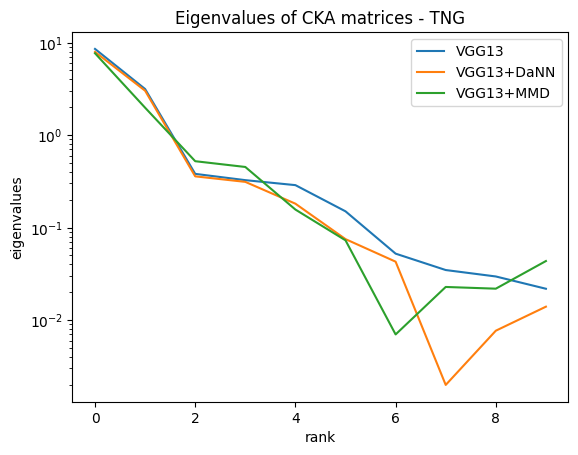

In [14]:
import numpy as np
import matplotlib.pyplot as plt

heatmap_CNN21 = np.load("heatmap/Layer21_TNG(norm).npy")
heatmap_VGG13 = np.load("heatmap/VGG13_1param_TNG.npy")
heatmap_VGG13_DaNN = np.load("heatmap/VGG13+DaNN_TNG(norm).npy")
heatmap_VGG13_MMD = np.load("heatmap/MMD_1param_TNG.npy")
eigenvalues_cnn21, _ = np.linalg.eig(heatmap_CNN21)
eigenvalues_vgg13, _ = np.linalg.eig(heatmap_VGG13)
eigenvalues_vgg13_dann, _ = np.linalg.eig(heatmap_VGG13_DaNN)
eigenvalues_vgg13_mmd, _ = np.linalg.eig(heatmap_VGG13_MMD)
# plt.plot(eigenvalues_cnn21, label='CNN21')
plt.plot(eigenvalues_vgg13[:10], label='VGG13')
plt.plot(eigenvalues_vgg13_dann[:10], label='VGG13+DaNN')
plt.plot(eigenvalues_vgg13_mmd[:10], label='VGG13+MMD')
plt.legend()
plt.yscale('log')
plt.xlabel('rank')
plt.ylabel('eigenvalues')
plt.title('Eigenvalues of CKA matrices - TNG')
plt.savefig('eigenvalue_TNG.png')
plt.show()


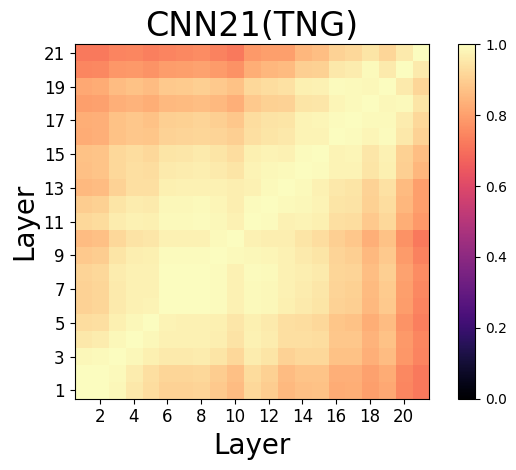

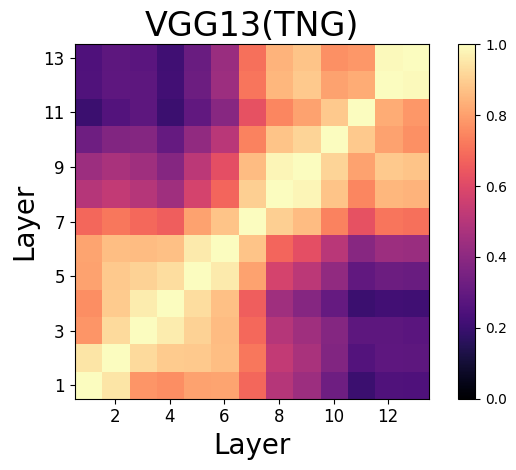

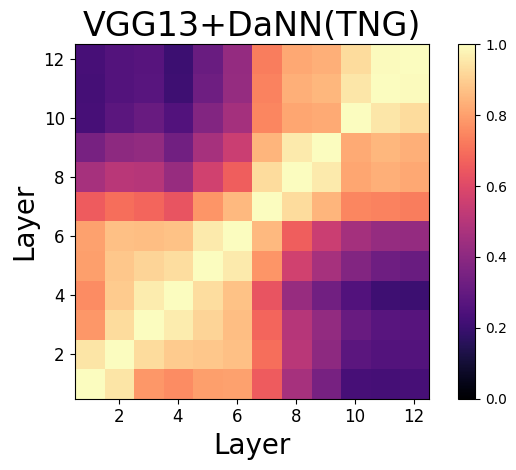

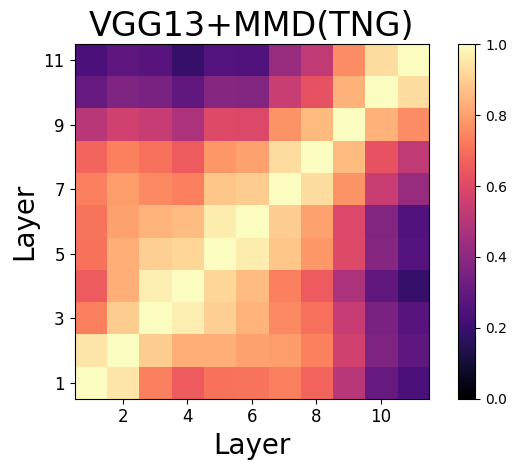

In [15]:
plotHeatmap(heatmap_CNN21, "CNN21(TNG)")
plotHeatmap(heatmap_VGG13, "VGG13(TNG)")
plotHeatmap(heatmap_VGG13_DaNN, "VGG13+DaNN(TNG)")
plotHeatmap(heatmap_VGG13_MMD, "VGG13+MMD(TNG)")

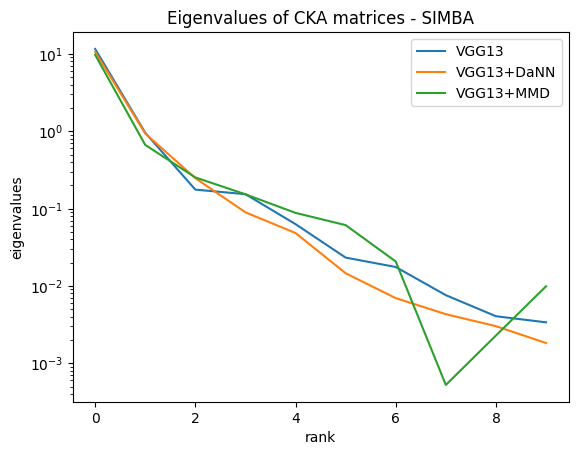

In [9]:
import numpy as np
import matplotlib.pyplot as plt

heatmap_CNN21 = np.load("heatmap/Layer21_SIMBA(norm).npy")
heatmap_VGG13 = np.load("heatmap/VGG13_1param_SIMBA.npy")
heatmap_VGG13_DaNN = np.load("heatmap/VGG13+DaNN_SIMBA(norm).npy")
heatmap_VGG13_MMD = np.load("heatmap/MMD_1param_SIMBA.npy")
eigenvalues_cnn21, _ = np.linalg.eig(heatmap_CNN21)
eigenvalues_vgg13, _ = np.linalg.eig(heatmap_VGG13)
eigenvalues_vgg13_dann, _ = np.linalg.eig(heatmap_VGG13_DaNN)
eigenvalues_vgg13_mmd, _ = np.linalg.eig(heatmap_VGG13_MMD)
# plt.plot(eigenvalues_cnn21, label='CNN21')
plt.plot(eigenvalues_vgg13[:10], label='VGG13')
plt.plot(eigenvalues_vgg13_dann[:10], label='VGG13+DaNN')
plt.plot(eigenvalues_vgg13_mmd[:10], label='VGG13+MMD')
plt.legend()
plt.yscale('log')
plt.xlabel('rank')
plt.ylabel('eigenvalues')
plt.title('Eigenvalues of CKA matrices - SIMBA')
plt.savefig('eigenvalue_SIMBA.png')
plt.show()


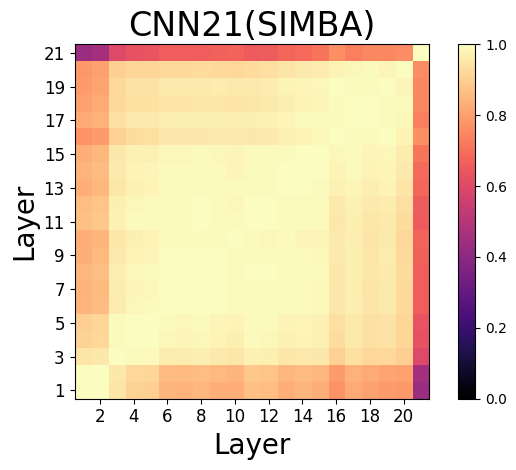

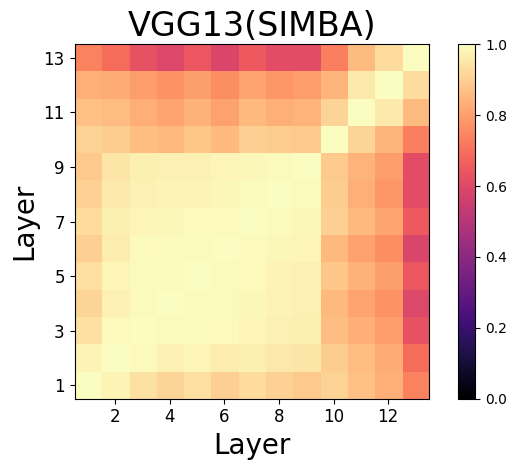

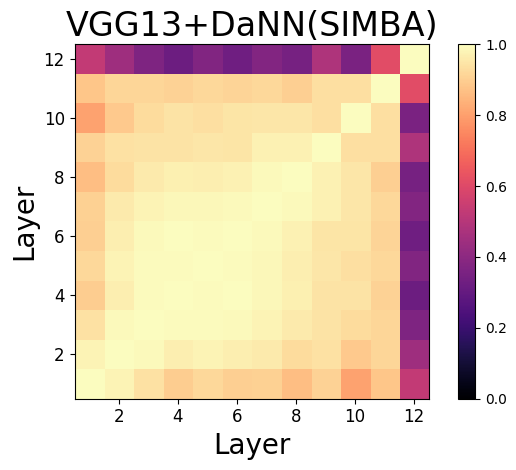

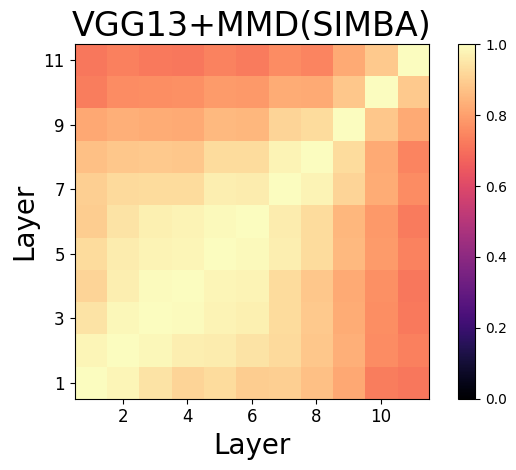

In [10]:
plotHeatmap(heatmap_CNN21, "CNN21(SIMBA)")
plotHeatmap(heatmap_VGG13, "VGG13(SIMBA)")
plotHeatmap(heatmap_VGG13_DaNN, "VGG13+DaNN(SIMBA)")
plotHeatmap(heatmap_VGG13_MMD, "VGG13+MMD(SIMBA)")

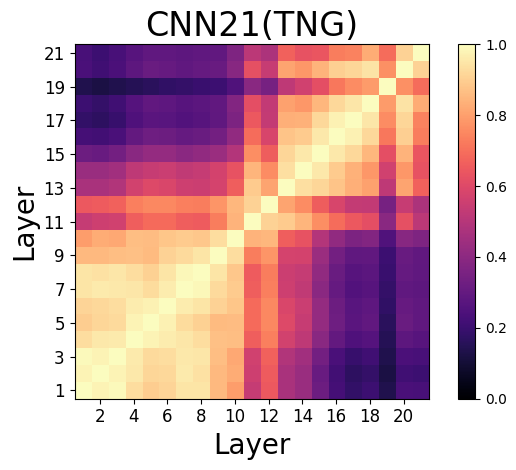

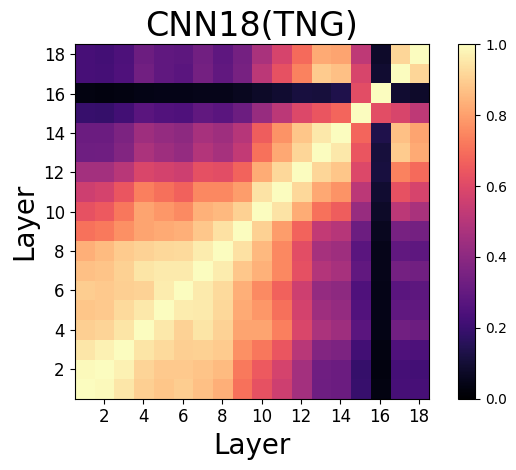

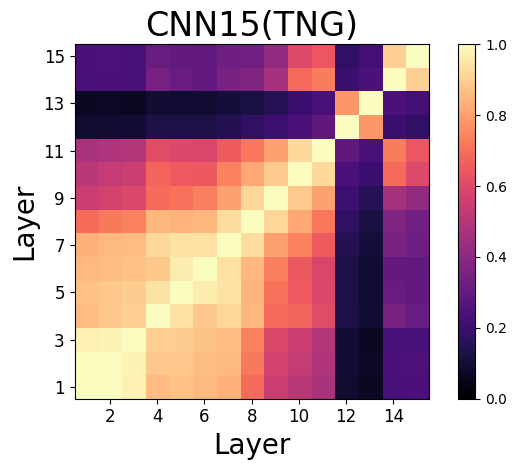

In [11]:
heatmap_CNN21 = np.load("heatmap/Layer21_TNG.npy")
heatmap_CNN18 = np.load("heatmap/Layer18_TNG.npy")
heatmap_CNN15 = np.load("heatmap/Layer15_TNG.npy")
plotHeatmap(heatmap_CNN21, "CNN21(TNG)")
plotHeatmap(heatmap_CNN18, "CNN18(TNG)")
plotHeatmap(heatmap_CNN15, "CNN15(TNG)")
